# Absentee Analysis

### Data Exploration

- Before we can do any analysis, we must first dive into the data and understand it first.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
df = pd.read_csv('absenteeism_data.csv', sep=';')

print("Victory")
df.head()

# look at Social Drinker column. we have both "Y" and "Yes".
# there are also lots of NaN values

Matplotlib is building the font cache; this may take a moment.


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.0,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.0,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.0,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2


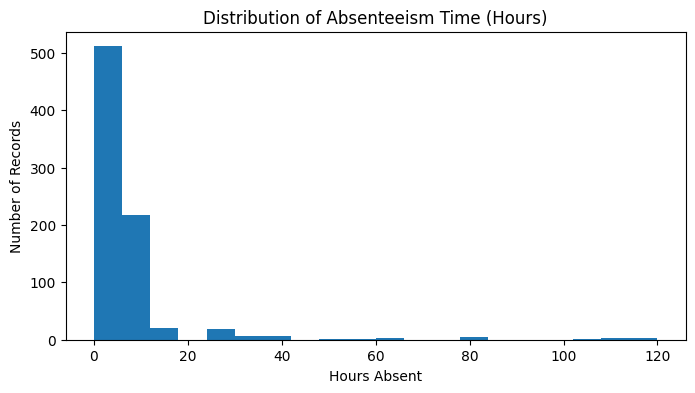

In [2]:
# First, lets visualize the distribution of how many entries correspond with how many hours were absent (via a histogram)
plt.figure(figsize=(8,4))
plt.hist(df['Absenteeism time in hours'], bins=20)
plt.title("Distribution of Absenteeism Time (Hours)")
plt.xlabel("Hours Absent")
plt.ylabel("Number of Records")
plt.show()

# note: some outliers

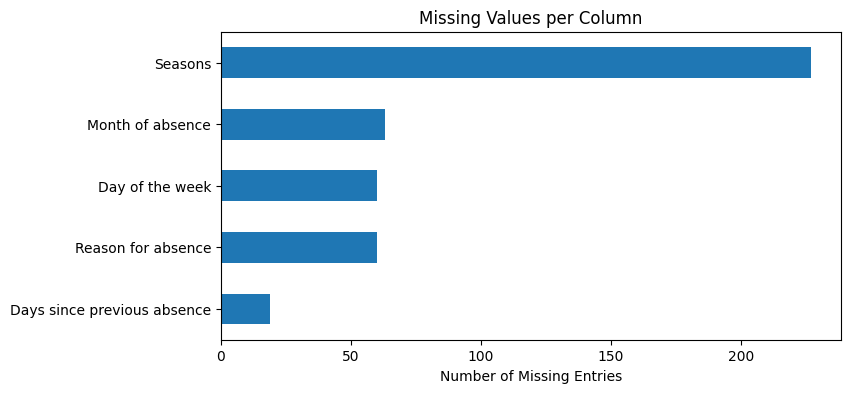

In [3]:
# Let's identify where we are missing values in our dataset
missing = df.isna().sum()
missing = missing[missing > 0]

plt.figure(figsize=(8,4))
missing.sort_values().plot(kind='barh')
plt.title("Missing Values per Column")
plt.xlabel("Number of Missing Entries")
plt.show()

# note: lots of missing data we need to pre-process properly

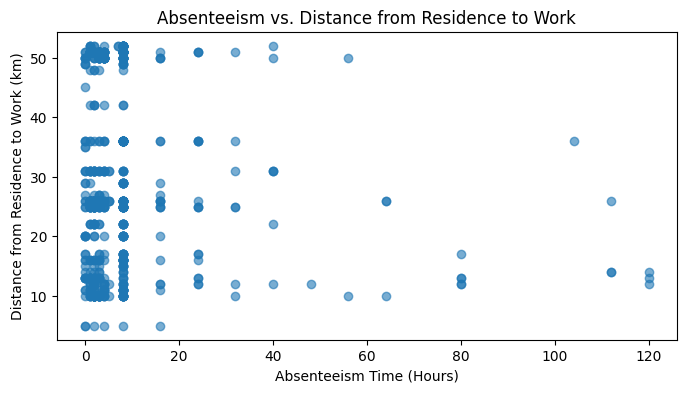

In [4]:
# Let's do a comparison between being absent and the distance they live from work.

plt.figure(figsize=(8,4))
plt.scatter(df['Absenteeism time in hours'], df['Distance from Residence to Work'], alpha=0.6)
plt.title("Absenteeism vs. Distance from Residence to Work")
plt.xlabel("Absenteeism Time (Hours)")
plt.ylabel("Distance from Residence to Work (km)")
plt.show()

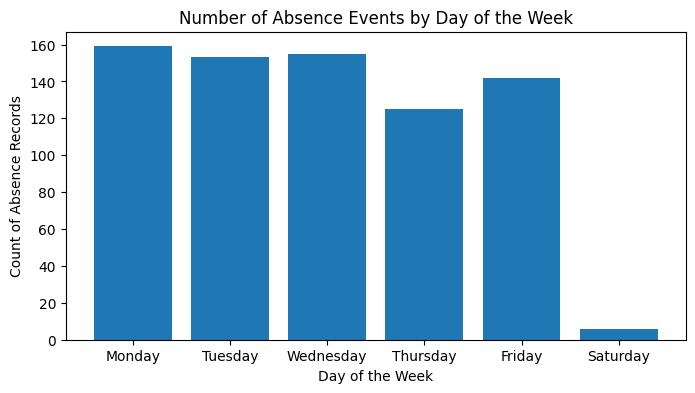

In [5]:
# Is there a correlation between the day of the week and absenteeism?
day_counts = df['Day of the week'].value_counts()

# I want the graph to visualize it in order from Monday - Sunday (not alphabetical)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = day_counts.reindex(weekday_order)

plt.figure(figsize=(8,4))
plt.bar(day_counts.index, day_counts.values)
plt.title("Number of Absence Events by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count of Absence Records")
plt.show()


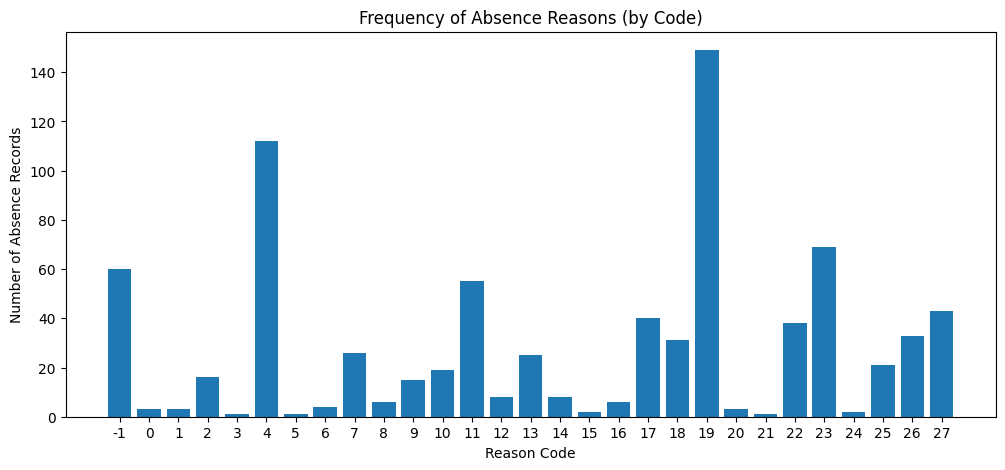

,Reason Code,Reason for absence
0,-1,NaN
1,0,Blood donation
2,1,Certain conditions originating in the perinata...
3,2,Certain infectious and parasitic diseases
4,3,"Congenital malformations, deformations and chr..."
5,4,Dental consultation
6,5,Diseases of the blood and blood-forming organs...
7,6,Diseases of the circulatory system
8,7,Diseases of the digestive system
9,8,Diseases of the ear and mastoid process


In [6]:
# Assign a numeric code to each reason
df['Reason Code'] = df['Reason for absence'].astype('category').cat.codes

reason_counts = df['Reason Code'].value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.bar(reason_counts.index.astype(str), reason_counts.values)
plt.title("Frequency of Absence Reasons (by Code)")
plt.xlabel("Reason Code")
plt.ylabel("Number of Absence Records")
plt.show()

# Create the corresponding code table as a reference
reason_lookup = (
    df[['Reason Code', 'Reason for absence']]
    .drop_duplicates()
    .sort_values("Reason Code")
    .reset_index(drop=True)
)

reason_lookup